In [2]:
%matplotlib inline
import json
import numpy as np
import sklearn.cluster as cluster
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import os
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [3]:
def parse_data_file(path):
    data = []
    with open(path, 'r') as fp:
        for line in fp:
            point = json.loads(line)
            text = point['text']
            data.append(text)
    return data

In [17]:
# create set to hold the unique words
set_of_words = set()
#typical stop words....from https://kb.yoast.com/kb/list-stop-words/
stop_list = set([ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are",\
                 "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",\
                 "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further",\
                 "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself",\
                 "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it",\
                 "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only",\
                 "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll",\
                 "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them",\
                 "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've",\
                 "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll",\
                 "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who",\
                 "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your",\
                 "yours", "yourself", "yourselves"])

# loop through words and add to set
for tweet in parse_data_file('tweets.json'):
    for word in map(lambda x: x.lower(),tweet.split()): #make sure to ignore case
        word = "".join(c for c in word if c not in ",:#_.").lower()
        if word in stop_list or 'http' in word or word.startswith("@") or word == 'rt': 
            continue
        elif word in set_of_words:
            continue
        else:
            set_of_words.add(word)
# convert set to ordered list.
list_of_words = sorted(list(set_of_words))
dic_of_words = {} # create dictionary to hold unique index of word
veclength = len(list_of_words) # this will be length of each vector that represents a tweet
numtweets = len(parse_data_file('tweets.json')) # the number of tweets...should be 251
for index,word in enumerate(list_of_words):
    dic_of_words[word] = index
veclength,numtweets

(276, 251)

Text(159,0.5,'Tweet identifier')

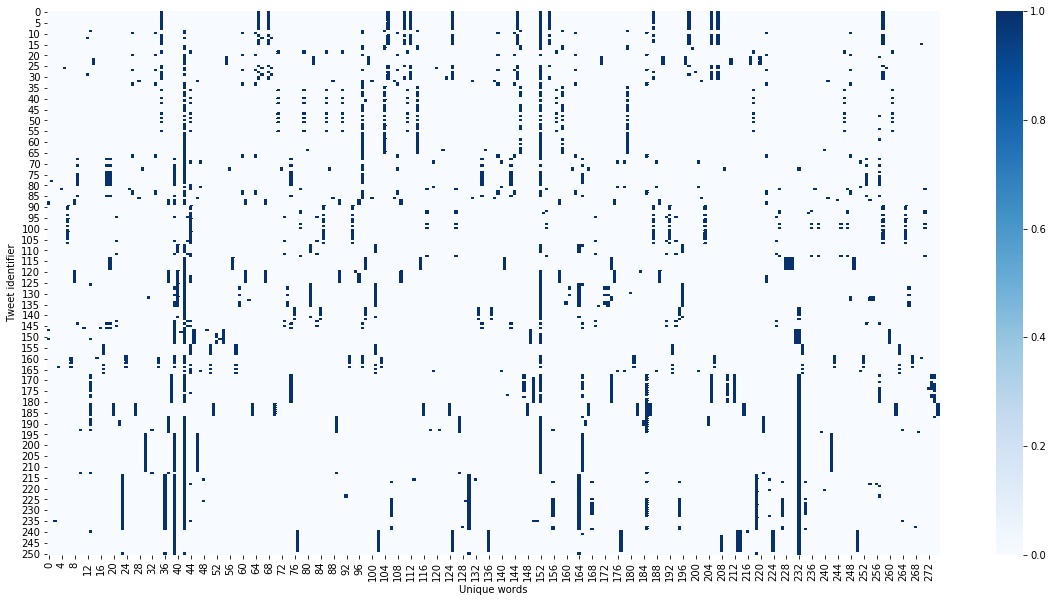

In [18]:
features = np.zeros((numtweets,veclength)) # creates numpy matrix to house features
##################################################
for tindex,tweet in enumerate(parse_data_file('tweets.json')):
    for word in map(lambda x: x.lower(),tweet.split()):
        word = "".join(c for c in word if c not in ",:#_.").lower()
        if word in stop_list or 'http' in word or word.startswith("@") or word == 'rt': #ignore link shares by not including http
            continue
        else:
            features[tindex][dic_of_words[word]] = 1 # set element to one for bag of word representation.
fig,ax = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(features,cmap='Blues')
ax.set_xlabel("Unique words")
ax.set_ylabel("Tweet identifier")

Text(0.5,1,'Elbow curve')

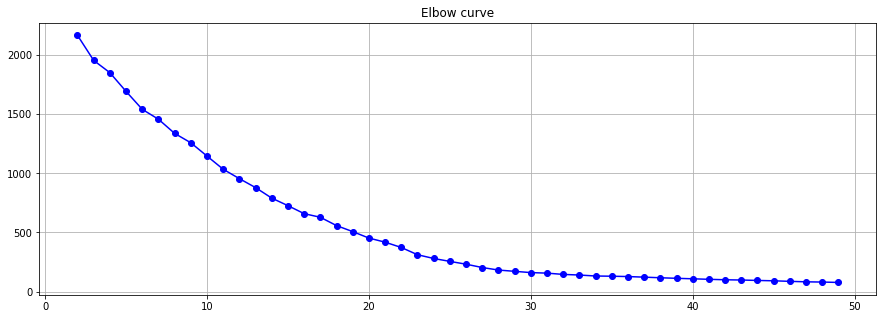

In [19]:
# lets run k all the way up to 50 to get a good look at the curve
distorsions = []
for k in range(2, 50):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(features)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 50), distorsions, 'bo-')
plt.grid(True)
plt.title('Elbow curve')

In [29]:
# choosing elbow as 22...but this is highly subjective
k = 22
kmeans = cluster.KMeans(n_clusters=k,random_state=1)
clusters = kmeans.fit_predict(features)
state = [x+1 for x in range(len(parse_data_file('tweets.json')))]
assignments = list(zip(state, clusters))
groupings = defaultdict(list)
state_g = dict()
for s, c in assignments:
    groupings[c].append(s)
    state_g[s] = c
groupings_list = [(x,groupings[x],len(groupings[x])) for x in groupings]
groupings_list=sorted(groupings_list,key=lambda x:x[2],reverse=True)
for group in groupings_list:
    print(group)

(5, [10, 17, 18, 36, 38, 39, 40, 42, 44, 45, 46, 47, 49, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], 27)
(3, [33, 73, 74, 87, 138, 139, 140, 141, 143, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213], 27)
(4, [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 26, 27, 29, 30, 31, 32], 20)
(1, [22, 23, 24, 25, 109, 110, 111, 112, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 142], 20)
(14, [215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 235, 236, 237, 238, 251], 15)
(7, [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181], 13)
(13, [69, 72, 75, 76, 77, 78, 79, 80, 81, 86, 145, 147], 12)
(2, [91, 92, 95, 97, 98, 100, 102, 103, 104, 105, 106, 108], 12)
(6, [218, 226, 227, 228, 229, 230, 231, 232, 233, 234, 239, 240], 12)
(9, [241, 242, 243, 244, 245, 246, 247, 248, 249, 250], 10)
(10, [11, 21, 28, 34, 35, 67, 68, 84, 85], 9)
(12, [19, 20, 37, 41, 43, 48, 50, 52, 56], 9)
(8, [88, 89, 90, 121, 122, 123, 124, 125, 126

Descriptions of the top five clusters in descending order are as follows:
1. "Google Person Finder Locates Missing at Boston Marathon Explosion" - people were tweeting about how to find persons that were missing using a google service.
2. "Boston Marathon terror bombing suspect has been arrested / surveillance" - the bomber has been apprehended and some tweets about the surveillance.
3. "FBI releases new details on Boston Marathon bombs" - Federal police release what new info they have on the bombs
4. "Reports of Marathon Runners that crossed finish line and continued to run to Mass General Hospital to give blood to victims #PrayforBoston" - people are amazed by the courage of the Boston Marathon runner who continue on running to the nearest hospital to give blood.
5. "New Aerial Images Show Boston Bombing Suspect In Boat" - suspect of the Boston Bombings perhaps in a boat near the harbor. Police in pursuit..